In [50]:
# When in Kaggle only: Run this first, everytime. Then restart by selecting clear and run and DO NOT FACTORY RESET 
# !pip install -U tensorflow==2.13.1

In [51]:
# pip install tensorflow

In [52]:
# pip install keras

In [86]:
print("TensorFlow version:", tensorflow.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.15.0
Keras version: 2.15.0


In [87]:
# Import libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

import nltk
from nltk.corpus import stopwords
import tensorflow 
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
import pickle


##### Replace with relative path

In [55]:
# df = pd.read_csv('/kaggle/input/kappa-labeled-train-2/kappa_labeled_train.csv')
df = pd.read_csv('../Data/kappa_labeled_train.csv')

In [56]:
df['cohen_kappa_label'].value_counts(normalize=True)

cohen_kappa_label
0.2    0.482409
0.5    0.250343
0.3    0.174098
0.6    0.065367
0.4    0.010780
0.0    0.010241
0.7    0.003724
0.1    0.002940
0.6    0.000049
0.8    0.000049
Name: proportion, dtype: float64

#### Rebin Values - Do not Run / Use

In [57]:

df['cohen_kappa_label_reformatted'] = pd.cut(df['cohen_kappa_label'],
                                              bins=[-float('inf'), 0.1, 0.2, 0.4, 0.6, 0.8, float('inf')],
                                              labels=[0.0,0.2, 0.4, 0.6, 0.8, 1.0],
                                              right=True)

# Display the reformatted column
print(df[['cohen_kappa_label', 'cohen_kappa_label_reformatted']])
print(df['cohen_kappa_label_reformatted'].value_counts(normalize=True))

       cohen_kappa_label cohen_kappa_label_reformatted
0                    0.2                           0.2
1                    0.0                           0.0
2                    0.2                           0.2
3                    0.5                           0.6
4                    0.2                           0.2
...                  ...                           ...
20403                0.2                           0.2
20404                0.2                           0.2
20405                0.2                           0.2
20406                0.2                           0.2
20407                0.6                           0.8

[20408 rows x 2 columns]
cohen_kappa_label_reformatted
0.2    0.482409
0.6    0.250392
0.4    0.184878
0.8    0.069140
0.0    0.013181
1.0    0.000000
Name: proportion, dtype: float64


In [58]:
df['cohen_kappa_label_reformatted'].value_counts(normalize=True)

cohen_kappa_label_reformatted
0.2    0.482409
0.6    0.250392
0.4    0.184878
0.8    0.069140
0.0    0.013181
1.0    0.000000
Name: proportion, dtype: float64

In [59]:
df.head()

,Unnamed: 0.1,Unnamed: 0,abstracts_headlines,section_name,cohen_kappa_label,cohen_kappa_range_none_to_slight,cohen_kappa_range_fair,cohen_kappa_range_moderate,cohen_kappa_range_substantial,cohen_kappa_range_almost_perfect,cohen_kappa_range_nan,cohen_kappa_label_reformatted
0,0,0,new start treaty nearly wrapped president obama begin discussing far reaching deals russia next treaties,1,0.2,1,0,0,0,0,0,0.2
1,1,1,response plea israel release jonathan pollard plea pollard release,1,0.0,0,0,0,0,0,1,0.0
2,2,2,letters editor regarding tensions new york medical schools caribbean doctors learn best,1,0.2,1,0,0,0,0,0,0.2
3,3,3,canada beat united states semifinals world junior tournament advancing final th consecutive year canada beats united states world junior semifinal,0,0.5,0,0,1,0,0,0,0.6
4,4,4,kristine lilly holds world record international appearances u announced retirement wednesday lilly iron lady u soccer retires,0,0.2,1,0,0,0,0,0,0.2


In [60]:
# Remove Stopwords and create two lists containing headlines/articles and their labels
articles = []
labels = []

for index, row in df.iterrows():
  labels.append(row['cohen_kappa_label'])

  token_list = [x for x in row['abstracts_headlines'].split() if x not in stopwords.words('english')]

  articles.append(" ".join(token_list))

### Train Test Modeling Prerequisites

In [61]:
X_train, X_test, y_train, y_test = train_test_split(articles, labels, random_state=42, test_size=0.2)

In [62]:
# Define variables

 # Max number of words
 # Word Vector dimension
 # Max length of the sequence
 # Where to chop off the seq
 # Where to put padding
 # Define some variables
vocab_size = 23100 # max number of words equiv of max_features for vectorizers
embedding_dim = 100 # this is the dimension of the Word Vector
max_length = 78 # maximum length of the sequence
trunc_type = 'post' # where to cut off
padding_type = 'post' # where to put the padding
oov_token = '<OOV>'

'''
print(vocab_size)
print(embedding_dim)
print(max_length)
23081
100
77
'''

'\nprint(vocab_size)\nprint(embedding_dim)\nprint(max_length)\n23081\n100\n77\n'

#### Tokenize

In [63]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token = oov_token)

#### Fit Tokenizer

In [64]:
tokenizer.fit_on_texts(X_train)

In [65]:
tokenizer.word_index;

#### Sequence train

In [66]:
train_seq = tokenizer.texts_to_sequences(X_train)

#### Pad Sequence

In [67]:
train_padded = pad_sequences(train_seq, maxlen = max_length, padding = padding_type, truncating = trunc_type)

In [68]:
test_seq = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_seq, maxlen = max_length, padding = padding_type, truncating = trunc_type)

In [69]:
X_test_precoded = X_test
y_test_precoded = y_test

#### Label Encoder

### When joining preds with test to check as a dataframe don't run these following transforms

In [70]:
le = LabelEncoder()


y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [71]:
y_test[:15]

array([2, 2, 2, 3, 2, 2, 5, 5, 2, 2, 3, 3, 3, 2, 2])

In [72]:
le.classes_

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.6, 0.7, 0.8])

#### Create Categories

In [73]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [74]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Initial Attempt

In [75]:
from tensorflow.keras.optimizers import schedules

##### Replace output layer with the number of your label classes - original model used 5 but this current model uses 10 etc. etc. 

In [77]:
model_11 = Sequential()
model_11.add(keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length))
model_11.add(keras.layers.Bidirectional(LSTM(64, return_sequences=True)))
model_11.add(keras.layers.Dropout(0.1))
model_11.add(keras.layers.Bidirectional(LSTM(32)))
model_11.add(keras.layers.Dropout(0.1))
model_11.add(keras.layers.Dense(8, activation='relu'))  # Added a dense layer with two that sum to 16 this is better than a single of 16 try 4 with 4
model_11.add(keras.layers.Dropout(0.1))
model_11.add(keras.layers.Dense(8, activation='relu'))  # Added a dense layer
model_11.add(keras.layers.Dropout(0.1))
model_11.add(keras.layers.Dense(10, activation='softmax'))

initial_learning_rate = 0.005
lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.7, staircase=True
)

optimizer = Adam(learning_rate=lr_schedule, clipvalue=0.5)

model_11.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc', 'mse'])

# Adding early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_11 = model_11.fit(
    train_padded, y_train,
    validation_data=(test_padded, y_test),
    batch_size=512,
    epochs=35,  # Set a smaller number of epochs
    verbose='auto',
    callbacks=[early_stopping]
)


Epoch 1/35
32/32 [==============================] - 39s 1s/step - loss: 2.1570 - acc: 0.2435 - mse: 0.0873 - val_loss: 1.8747 - val_acc: 0.2553 - val_mse: 0.0819
Epoch 2/35
32/32 [==============================] - 29s 913ms/step - loss: 1.6446 - acc: 0.2759 - mse: 0.0753 - val_loss: 1.3920 - val_acc: 0.5826 - val_mse: 0.0677
Epoch 3/35
32/32 [==============================] - 29s 922ms/step - loss: 1.3104 - acc: 0.5548 - mse: 0.0655 - val_loss: 1.2274 - val_acc: 0.5860 - val_mse: 0.0607
Epoch 4/35
32/32 [==============================] - 30s 934ms/step - loss: 1.0574 - acc: 0.6091 - mse: 0.0544 - val_loss: 1.1171 - val_acc: 0.6350 - val_mse: 0.0509
Epoch 5/35
32/32 [==============================] - 29s 890ms/step - loss: 0.8014 - acc: 0.7116 - mse: 0.0405 - val_loss: 1.0353 - val_acc: 0.6828 - val_mse: 0.0449
Epoch 6/35
32/32 [==============================] - 29s 921ms/step - loss: 0.5935 - acc: 0.7834 - mse: 0.0298 - val_loss: 1.0363 - val_acc: 0.6938 - val_mse: 0.0446
Epoch 7/35
32

##### Plot to visualize performance 

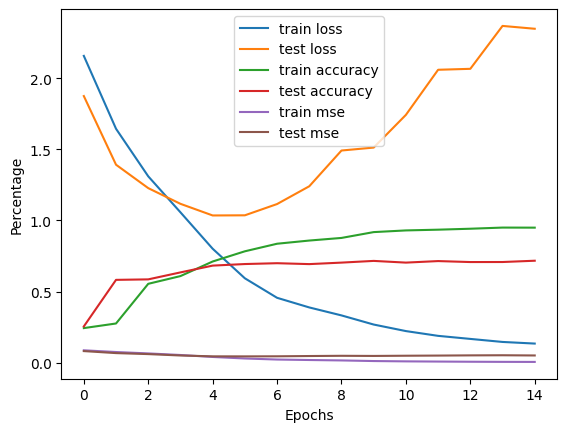

In [78]:
plt.plot(history_11.history['loss'], label='train loss')
plt.plot(history_11.history['val_loss'], label='test loss')
plt.plot(history_11.history['acc'], label='train accuracy')
plt.plot(history_11.history['val_acc'], label='test accuracy')
plt.plot(history_11.history['mse'], label='train mse')
plt.plot(history_11.history['val_mse'], label='test mse')
plt.xlabel('Epochs')
plt.ylabel('Percentage')
plt.legend()
plt.show;

# Evaluate the model¶


In [79]:
pred = np.argmax(model_11.predict(test_padded), axis = 1)


128/128 [==============================] - 4s 18ms/step


In [80]:
pred_labels = le.inverse_transform(pred)


In [81]:
np.mean(pred_labels)

0.28294953454189126

# Use the following for entries to reference in order to test the streamlit app

In [82]:
pred_labels = le.inverse_transform(pred) 

# Create a new DataFrame - Now do not need to run top cells
test_combined_df = pd.DataFrame({'Articles': X_test_precoded, 'Actual Labels': y_test_precoded, 'Predicted Labels': pred_labels})

In [83]:
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)

test_combined_df

,Articles,Actual Labels,Predicted Labels
0,amid logistical challenges voting pandemic despite threats foreign interference violence disinformation machinery democracy held quite well warnings could go rails election actually ran smoothly,0.2,0.3
1,readers vented frustration political system cheered elizabeth warren combative rhetoric status quo reaction david brooks column warren win readers respond warren win,0.2,0.2
2,new accord denies permanently rule south korea right enrich uranium reprocess spent nuclear fuel even peaceful purposes u south korea reach revised nuclear deal,0.2,0.3
3,optimistic possible supreme court ruling law lawmakers giving past proposals second look lowering health costs priority looking ahead republicans examine options health care fight,0.3,0.3
4,f b scored two major victories recovering bitcoin ransom tricking lawbreakers encryption app criminals may still upper hand bitcoin encryption race criminals f b,0.2,0.2
...,...,...,...
4077,christian conservatives dealing loss presidency also many see rejection agenda including fights sex marriage christian right failed sway voters issues,0.2,0.3
4078,even people try get recognition social awareness others calling trying score points earning woke badge,0.2,0.2
4079,judge clay jenkins dallas county chief executive said people contact thomas eric duncan cleared overnight twice daily monitoring days showing symptoms u ebola watch list cleared,0.2,0.2
4080,agnostic guide president strange conduct trump russia one mystery three theories,0.3,0.2


##### Uncomment to save model, recommend using `h5` for `Streamlit` compatibility. 

In [91]:
# Ready to save - uncomment
model_11.save('model_11_new.hdf5')
# model_11.save('model_11_72test.keras')


/Users/ben/miniforge3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Following is for Streamlit purposes. Must save with custom serialization for model to be loaded within Streamlit app. 

In [88]:
model_11.get_config()

{'name': 'sequential_2',
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 78),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'embedding_2_input'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Embedding',
   'config': {'name': 'embedding_2',
    'trainable': True,
    'dtype': 'float32',
    'batch_input_shape': (None, 78),
    'input_dim': 23100,
    'output_dim': 100,
    'embeddings_initializer': {'module': 'keras.initializers',
     'class_name': 'RandomUniform',
     'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None},
     'registered_name': None},
    'embeddings_regularizer': None,
    'activity_regularizer': None,
    'embeddings_constraint': None,
    'mask_zero': False,
    'input_length': 78},
   'registered_name': None,
   'build_config': {'input_shape': (None, 78)}},
  {'module': 'keras.layers',
   'class_name': 'Bidirectional',
   'config': {

### Model Architecture (Same as above must save for Streamlit)

In [94]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import schedules

class CustomLayer(tf.keras.layers.Layer):
    def __init__(self, sublayer, **kwargs):
        super().__init__(**kwargs)
        self.sublayer = sublayer  # Fixed typo: change 'layer' to 'sublayer'

    def call(self, x):
        return self.sublayer(x)

    def get_config(self):
        base_config = super().get_config()
        config = {
            "sublayer": tf.keras.saving.serialize_keras_object(self.sublayer),
        }
        return {**base_config, **config}

    @classmethod
    def from_config(cls, config):
        sublayer_config = config.pop("sublayer")
        sublayer = tf.keras.saving.deserialize_keras_object(sublayer_config)
        return cls(sublayer, **config)

# Create your model with the custom layer
model_11 = Sequential()
model_11.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model_11.add(Bidirectional(LSTM(64, return_sequences=True)))
model_11.add(Dropout(0.1))
model_11.add(Bidirectional(LSTM(32)))
model_11.add(Dropout(0.1))
model_11.add(Dense(8, activation='relu'))  
model_11.add(Dropout(0.1))
model_11.add(Dense(8, activation='relu'))
model_11.add(Dropout(0.1))
model_11.add(Dense(10, activation='softmax'))

initial_learning_rate = 0.005
lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.7, staircase=True
)

optimizer = Adam(learning_rate=lr_schedule, clipvalue=0.5)

model_11.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc', 'mse'])

# Adding early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_11 = model_11.fit(
    train_padded, y_train,
    validation_data=(test_padded, y_test),
    batch_size=512,
    epochs=35,  # Set a smaller number of epochs
    verbose='auto',
    callbacks=[early_stopping]
)
# Save the model with custom serialization - Uncomment when ready to save - Replace with your relative path
# model_11.save("/Users/ben/Desktop/DSI_GA_Materials/capstone/Capstone_Project_backup/model_11_serial", save_format="tf", signatures=None, options=None)



Epoch 1/35
32/32 [==============================] - 38s 934ms/step - loss: 1.8805 - acc: 0.3656 - mse: 0.0785 - val_loss: 1.4161 - val_acc: 0.4662 - val_mse: 0.0661
Epoch 2/35
32/32 [==============================] - 29s 916ms/step - loss: 1.2831 - acc: 0.5164 - mse: 0.0599 - val_loss: 1.1880 - val_acc: 0.5321 - val_mse: 0.0561
Epoch 3/35
32/32 [==============================] - 30s 937ms/step - loss: 0.9853 - acc: 0.6520 - mse: 0.0461 - val_loss: 1.0775 - val_acc: 0.6565 - val_mse: 0.0483
Epoch 4/35
32/32 [==============================] - 29s 898ms/step - loss: 0.7473 - acc: 0.7678 - mse: 0.0343 - val_loss: 1.0191 - val_acc: 0.6813 - val_mse: 0.0458
Epoch 5/35
32/32 [==============================] - 27s 849ms/step - loss: 0.5677 - acc: 0.8249 - mse: 0.0260 - val_loss: 1.0774 - val_acc: 0.6933 - val_mse: 0.0458
Epoch 6/35
32/32 [==============================] - 27s 834ms/step - loss: 0.4568 - acc: 0.8575 - mse: 0.0209 - val_loss: 1.2154 - val_acc: 0.6950 - val_mse: 0.0477
Epoch 7/35

INFO:tensorflow:Assets written to: /Users/ben/Desktop/DSI_GA_Materials/capstone/Capstone_Project_backup/model_11_serial/assets


### Now we transition to Continuous Bag of Words and Skip Grams files. 